# Colab 사용자를 위한 안내

해당 노트북은 **로컬** 환경에서 최적화 되어 있습니다. 로컬 환경에서 진행하시는 분들은 바로 학습을 진행하시면 됩니다.

Colab 을 사용하시는 분들은 처음에 아래 주석을 해제하시고 한번 만 실행시켜주세요!

* 주석을 해제하는 방법: 해당 영역을 선택하고, `Ctrl + /` 를 누르면 해당 영역의 주석에 해제됩니다.

In [1]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

Mounted at /content/gdrive


Colab 을 사용하시는 분들은 아래 주석을 해제하시고 `folder` 변수 명에 프로젝트 디렉토리를 저장한 위치를 작성해주세요! 예를 들어, `02_cnn_pt` 의 위치가 "내 드라이브 > colab_notebook > pytorch" 폴더 안에 있는 경우, "colab_notebook/tensorflow" 를 작성하시면 됩니다.

```python
folder = "colab_notebook/pytorch"
```

In [2]:
import os
from pathlib import Path

# folder 변수에 구글드라이브에 프로젝트를 저장한 디렉토리를 입력하세요!
folder = "Colab Notebooks"
project_dir = "02_cnn_pt"

base_path = Path("/content/gdrive/My Drive/")
project_path = base_path / folder / project_dir
os.chdir(project_path)
for x in list(project_path.glob("*")):
    if x.is_dir():
        dir_name = str(x.relative_to(project_path))
        os.rename(dir_name, dir_name.split(" ", 1)[0])
print(f"현재 디렉토리 위치: {os.getcwd()}")

현재 디렉토리 위치: /content/gdrive/My Drive/Colab Notebooks/02_cnn_pt


PyTorch 는 `1.1.0` 이상 버전을 기준으로 합니다. Colab 사용시, 첫번째 코드를 실행해보시고 만약에 버전이 다르다면 두 번째 주석을 해제하고 실행해주세요.

In [3]:
## 첫번째 코드블록
import torch 
print('pytorch version: {}'.format(torch.__version__))

pytorch version: 1.10.0+cu111


In [4]:
## 두번째 코드블록
# !pip install torch==1.1.0 torchvision==0.3.0

# Convolutional Neural Network: Cat-Dog Classifier

<img src="http://drive.google.com/uc?export=view&id=16c7SWB6wboraKe4OFRmSU6RywZhWB9Xc" width="600px" height="400px" />

* 이미지 출처: ImageNet Classification with Deep Convolutional Neural Networks(A Krizhevsky, 2012)
<br>
ImageNet classifcation challenge는 컴퓨터를 통해 총 1000가지 종류의 사물에 대한 이미지를 분류하는 대회입니다. 이 대회에서 모델 학습을 위해 제공하는 학습 이미지는 100만장이 훌쩍 넘습니다. 지난 수 년간 대회가 진행되었는데, 초창기에는 이 시각 인지(visual recognition) 문제를 인간만큼 잘 처리하는 알고리즘이 나오지 못했습니다. 하지만 2012년 CNN의 등장과 함께 엄청난 성능 향상이 시작되었습니다.

<img src="http://drive.google.com/uc?export=view&id=1twuxI3IlZbgF2glLKyGoD6yGh5LQZLys" width="800px" height="400px" />
<center>&lt;2012년 AlexNet이 등장하면서 CNN은 많은 주목을 받기 시작합니다&gt;</center></caption>

* 이미지 출처: [이곳](https://www.researchgate.net/figure/Winner-results-of-the-ImageNet-large-scale-visual-recognition-challenge-LSVRC-of-the_fig7_324476862)
<br>
2011년에 우승한 알고리즘의 오차율(error rate)이 26% 였는데, 2012년 CNN기반의 AlexNet이 1년만에 무려 10%의 오차율을 줄이면서 우승하게 되었습니다. 2015년에는 마찬가지로 CNN기반의 ResNet이 등장하면서 3.6%의 오차율을 기록했는데, 이는 실제 사람의 평균 오차율인 5%를 넘는 기록입니다. 이제 우리는 컴퓨터 알고리즘을 통해 사람보다 사물을 정확하게 인식할 수 있는 것입니다. 그리고 이러한 변화는 CNN의 등장과 함께 매우 짧은 시간에 이루어진 것이었습니다. 그래서 실제로 최근의 딥러닝의 인기는 CNN의 등장과 컴퓨터 비전(computer vision)분야의 엄청난 발전과 깊은 관련이 있다고 할 수 있습니다. 이번 프로젝트에서는 CNN을 직접 설계하여 고양이와 강아지를 분류하는 문제를 해결해 볼 것입니다. 여기에 약간의 제약 조건을 추가해, 상당히 적은 양의 데이터를 가지고도 매우 빠른 시간안에 높은 성능의 모델을 학습시키는 방법에 대해 배울 것입니다.

이번 실습의 목표는 다음과 같습니다.
- CNN을 설계하고 이미지 분류기를 학습시킨다.
- 학습 과정에서 데이터 증식(data augmentation)을 적용한다.
- 학습된 모델을 저장하고 불러올 수 있다.
- 전이학습(transfer learning)을 구현할 수 있다.

이번 과정을 통해 얻는 최종 결과물은 아래 그림과 같습니다.

<img src="http://drive.google.com/uc?export=view&id=12IySBKqWiWdBR-IjkKWW41czlAjEqm5U" width="800px" height="300px" />
<center>&lt;CNN을 통해 강아지와 고양이분류를 구현합니다&gt;</center></caption>

### 이제부터 본격적으로 프로젝트를 시작하겠습니다.

**"[TODO] 코드 구현"** 부분의 **"## 코드 시작 ##"** 부터 **"## 코드 종료 ##"** 구간에 필요한 코드를 작성해주세요. **나머지 작성구간이 명시 되지 않은 구간은 임의로 수정하지 마세요!**

실습코드는 Python 3.6, PyTorch 1.1.0 버전을 기준으로 작성되었습니다.

**본문 중간중간에 PyTorch 함수들에 대해 [Pytorch API 문서](https://pytorch.org/docs/stable/) 링크를 걸어두었습니다. API 문서를 직접 확인하는 일에 익숙해지면 나중에 여러분이 처음부터 모델을 직접 구현해야 할 때 정말 큰 도움이 됩니다.**

<h1>목차<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Colab-사용자를-위한-안내" data-toc-modified-id="Colab-사용자를-위한-안내-1">Colab 사용자를 위한 안내</a></span></li><li><span><a href="#Convolutional-Neural-Network:-Cat-Dog-Classifier" data-toc-modified-id="Convolutional-Neural-Network:-Cat-Dog-Classifier-2">Convolutional Neural Network: Cat-Dog Classifier</a></span><ul class="toc-item"><li><span><a href="#1.-Package-load" data-toc-modified-id="1.-Package-load-2.1">1. Package load</a></span></li><li><span><a href="#2.-데이터셋-다운로드-및-훈련,-검증,-테스트-데이터셋-구성" data-toc-modified-id="2.-데이터셋-다운로드-및-훈련,-검증,-테스트-데이터셋-구성-2.2">2. 데이터셋 다운로드 및 훈련, 검증, 테스트 데이터셋 구성</a></span></li><li><span><a href="#3.-하이퍼파라미터-세팅" data-toc-modified-id="3.-하이퍼파라미터-세팅-2.3">3. 하이퍼파라미터 세팅</a></span></li><li><span><a href="#4.-Dataset-및-DataLoader-할당" data-toc-modified-id="4.-Dataset-및-DataLoader-할당-2.4">4. Dataset 및 DataLoader 할당</a></span></li><li><span><a href="#5.-네트워크-설계" data-toc-modified-id="5.-네트워크-설계-2.5">5. 네트워크 설계</a></span></li><li><span><a href="#6.-train,-validation,-test-함수-정의" data-toc-modified-id="6.-train,-validation,-test-함수-정의-2.6">6. train, validation, test 함수 정의</a></span></li><li><span><a href="#7.-모델-저장-함수-정의" data-toc-modified-id="7.-모델-저장-함수-정의-2.7">7. 모델 저장 함수 정의</a></span></li><li><span><a href="#8.-모델-생성-및-Loss-function,-Optimizer-정의" data-toc-modified-id="8.-모델-생성-및-Loss-function,-Optimizer-정의-2.8">8. 모델 생성 및 Loss function, Optimizer 정의</a></span></li><li><span><a href="#9.-Training" data-toc-modified-id="9.-Training-2.9">9. Training</a></span></li><li><span><a href="#10.-저장된-모델-불러오기-및-test" data-toc-modified-id="10.-저장된-모델-불러오기-및-test-2.10">10. 저장된 모델 불러오기 및 test</a></span></li><li><span><a href="#11.-Transfer-Learning" data-toc-modified-id="11.-Transfer-Learning-2.11">11. Transfer Learning</a></span></li><li><span><a href="#12.-Summary" data-toc-modified-id="12.-Summary-2.12">12. Summary</a></span></li></ul></li><li><span><a href="#Self-Review" data-toc-modified-id="Self-Review-3">Self-Review</a></span></li></ul></div>

## 1. Package load
필요한 패키지들을 로드합니다.

In [6]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import check_util.checker as checker 
%matplotlib inline

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))
device = "cuda" if torch.cuda.is_available() else "cpu"   # GPU 사용 가능 여부에 따라 device 정보 저장

pytorch version: 1.10.0+cu111
GPU 사용 가능 여부: False


## 2. 데이터셋 다운로드 및 훈련, 검증, 테스트 데이터셋 구성
이번 실습에서는 고양이와 강아지 이미지를 분류하는 네트워크를 학습시킬 것입니다. 
우리가 이번에 사용할 데이터셋은 2013년 후반에 '캐글'이라는 데이터사이언스 대회 플랫폼에서 열린 컴퓨터 비전 경연 대회의 일환으로 제작되었습니다. 참고로 CNN을 사용한 참가자가 95% 정확도를 달성하여 당시 대회 우승을 차지했습니다. 

이번 예제에서 사용할 강아지-고양이 이미지 데이터셋 원본 출처는 [이곳](https://www.kaggle.com/c/dogs-vs-cats/data)입니다. 데이터셋은 편의상 미리 다운로드 받아 압축해 제공해드렸습니다. './data/my_cat_dog.zip'을 같은 경로인 'data' 폴더에 압축 해제하시기 바랍니다. 

Colab 사용자분들은 아래 주석을 해제하시고 실행하면 로컬에서 압축을 풀지 않고, Colab 환경에서 압축을 해제할 수 있습니다.

In [7]:
import zipfile
from pathlib import Path

current_path = Path().absolute()
data_path = current_path / "data"
print("현재 디렉토리 위치: {}".format(current_path))
if (data_path / "my_cat_dog").exists():
    print("이미 'data/my_cat_dog' 폴더에 압축이 풀려있습니다. 확인해보세요!")
else:
    with zipfile.ZipFile(str(data_path / "my_cat_dog.zip"), "r") as zip_ref:
        zip_ref.extractall(str(data_path / "my_cat_dog"))
    print("Done!")

현재 디렉토리 위치: /content/gdrive/MyDrive/Colab Notebooks/02_cnn_pt
Done!


원본 데이터셋에는 고양이와 강아지 이미지가 각각 12500개로 총 25000개의 학습용 데이터셋이 구성되어 있습니다. 
이 정도면 강아지와 고양이를 학습시키에는 어느정도 충분한 양입니다. 이번 실습에서 우리는 훨씬 더 적은 양의 데이터만 사용해 볼 것입니다. 이처럼 비교적 매우 적은 양의 데이터만 가지고도 많은 양의 데이터를 통해 학습시킨 모델에 크게 뒤지지 않는 모델을 학습시키는 방법에 대해서 배워볼 것입니다.

제공해드린 데이터셋에는, 훈련용 데이터가 class당 1000개, 검증용 데이터가 class당 500개, 마지막으로 테스트용 데이터는 class당 1000개로 구성되어 있습니다.  

In [8]:
data_dir = './data/my_cat_dog'  # 압축 해제된 데이터셋의 디렉토리 경로

아래의 코드를 실행하면 데이터셋 구성이 올바르게 되었는지 확인할 수 있습니다. 

다음과 같은 결과가 나온다면 데이터셋 구성이 정상적으로 이루어진 것입니다.

만약 아래와 같은 결과가 나오지 않는다면 `./data/my_cat_dog.zip`을 같은 경로인 'data' 폴더에 수동으로 압축 해제하시기 바랍니다.

```
훈련용 고양이 이미지 개수: 1000
훈련용 강아지 이미지 개수: 1000
검증용 강아지 이미지 개수: 500
검증용 강아지 이미지 개수: 500
테스트용 강아지 이미지 개수: 1000
테스트용 강아지 이미지 개수: 1000
```

In [9]:
checker.dataset_check(data_dir)

훈련용 고양이 이미지 개수: 1000
훈련용 강아지 이미지 개수: 1000
검증용 고양이 이미지 개수: 500
검증용 강아지 이미지 개수: 500
테스트용 고양이 이미지 개수: 1000
테스트용 강아지 이미지 개수: 1000


## 3. 하이퍼파라미터 세팅

학습에 필요한 하이퍼파라미터의 값을 초기화해줍니다. 하이퍼파라미터는 뉴럴네트워크를 통하여 학습되는 것이 아니라 학습율(learning rate), 사용할 레이어의 수 등 설계자가 결정해줘야 하는 값들을 의미합니다.

미니배치의 크기(`batch_size`), 학습 할 epoch 수(`num_epochs`), 학습률(`learning_rate`) 등의 값들을 다음과 같이 정했습니다.

In [13]:
batch_size = 100
num_epochs = 10
learning_rate = 0.0001

## 4. Dataset 및 DataLoader 할당

이제 우리가 사용할 데이터셋을 정의해야 합니다. 이전 실습에서는 PyTorch에 이미 정의되어 있는 FashionMNIST Dataset을 불러와서 사용하면 됐습니다. 따라서 따로 Dataset class를 구현해야 할 필요가 없었습니다. 

이번 예제에서도 ['Lab-10-4-1'](https://www.youtube.com/watch?v=KDVOAjaTnDU&list=PLQ28Nx3M4JrhkqBVIXg-i5_CVVoS1UzAv&index=22)강의에서 배웠던, PyTorch에 미리 정의되어 있는 ImageFolder Dataset class를 사용할 수 있습니다. 폴더에 맞게 라벨을 자동으로 지정해주는 매우 편리한 기능이죠. 하지만 PyTorch가 항상 입맛에 맞는 라벨을 미리 정의해 줄 수는 없습니다. 따라서 스스로 라벨을 정의하는 연습이 필요합니다.

Dataset class를 커스텀하기 위해서는 [torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) class를 상속하고, `__getitem__` 함수와 `__len__` 함수를 구현해야 합니다. 

* `__getitem__` 함수는 어떤 순번(index)를 인자로 받으면, 그에 상응하는 번호의 데이터를 반환하는 함수입니다. 
* `__len__` 함수는 정의하고자 하는 데이터셋의 총 데이터 개수를 반환하는 함수입니다. 

PyTorch 의 Dataset과 DataLoader에 대해 잘 기억나지 않는다면 ['Lab-04-2'](https://www.youtube.com/watch?v=B3VG-TeO9Lk&list=PLQ28Nx3M4JrhkqBVIXg-i5_CVVoS1UzAv&index=8&t=0s) 강의를 참고하시기 바랍니다.

생성자(`__init__`)는 아래에 미리 구현을 해두었습니다. 
* `self.all_data`는 정의하는 데이터셋에 포함된 모든 데이터 파일의 경로를 저장하고 있습니다. 인자로 받은 **mode**('train' 또는 'val' 또는 'test')에 따라 훈련용 혹은 검증용 혹은 테스트용 데이터셋을 구분합니다. `self.all_data`의 변수 type은 파이썬 리스트이며, 그 안에는 다음과 같은 형식으로 데이터 파일의 경로가 저장되어 있습니다.

>```python
self.all_data = ['./data/my_cat_dog/train/cat/cat.0.jpg', 
                 './data/my_cat_dog/train/cat/cat.1.jpg', 
                 ... ,
                 './data/my_cat_dog/train/dog/dog.0.jpg', 
                 './data/my_cat_dog/train/dog/dog.1.jpg', ...]
>```

* `self.transform`는 [transforms.Compose()](https://pytorch.org/docs/stable/torchvision/transforms.html?highlight=compose#torchvision.transforms.Compose)를 통해 구성된 데이터 전처리 모듈입니다. 

### <font color='red'>[TODO] 코드 구현</font>

다음을 읽고 코드를 완성해보세요. 

먼저 아래의 지시에 따라 `__getitem__` 함수를 완성해보세요.

**Step 1**: 반환할 이미지 경로 정의 및 이미지 로드
1. 인자로 받은 `index` 변수(integer)를 이용하여 `self.all_data` 리스트에서 그 인덱스에 해당하는 데이터 경로를 정의하고 `data_path` 변수에 저장하세요.
2. PIL패키지의 `Image.open` 을 통해 위에서 지정한 `data_path`에 있는 이미지를 PIL 이미지 객체로 변환하고, 그 결과를 `img` 라는 이름의 변수에 저장하세요. 
3. 만일 `self.transform` 에 정의된 것이 있다면, 즉 None이 아니라면, `img` 에 `self.transform`을 통해 데이터 전처리를 적용하세요. 그 결과는 다시 `img` 변수에 저장되어야 합니다. (`self.transform` 은 향후에 함수의 타입을 대입할 것입니다.)

**Step 2**: 이미지에 대한 라벨(label) 정의
- 마지막으로 데이터의 라벨(label)을 정의할 차례입니다. 만약 데이터 경로인 `data_path`가 고양이 이미지라면 `label` 변수에 `0`을, 강아지라면 `1`을 저장하세요. 데이터 파일의 파일 이름을 통해 이미지가 고양이인지 강아지인지 알 수 있습니다. (힌트: 사람에 따라 다양한 방식으로 구현할 수 있겠지만, [os.path.basename](https://docs.python.org/3/library/os.path.html) 함수를 이용하면 파일 경로 문자열에서 파일 이름(+확장자)만 분리할 수 있습니다. 그리고 [str.startswith](https://www.tutorialspoint.com/python/string_startswith.htm)을 활용하면 파일명이 "cat" 으로 시작하는지 혹은 "dog" 으로 시작하는지 알 수 있습니다.)

다음을 읽고 `__len__` 함수를 완성해보세요.
- 이 함수는 매우 간단합니다. 정의할 데이터셋의 총 데이터 개수를 `length` 변수에 저장하세요.

**이제 각 스텝에 따라 CatDogDataset 코드를 작성해보세요! "<font color='45A07A'>## 코드 시작 ##</font>"과 "<font color='45A07A'>## 코드 종료 ##</font>" 사이의 <font color='075D37'>None</font> 부분을 채우시면 됩니다.**

In [15]:
class CatDogDataset(Dataset):
    def __init__(self, data_dir, mode, transform=None):
        self.all_data = sorted(glob.glob(os.path.join(data_dir, mode, '*', '*')))
        self.transform = transform
    
    def __getitem__(self, index):
        # Step 1: 반환할 이미지 경로 정의 및 이미지 로드
        ## 코드 시작 ##
        data_path = self.all_data[index]    # 위의 설명 Step 1의 1. 을 참고하여 None을 채우세요.
        img = Image.open(data_path)          # 위의 설명 Step 1의 2. 를 참고하여 None을 채우세요.
        if self.transform != None:
          img = self.transform(img)                # 위의 설명 Step 1의 3. 을 참고하여 None을 채우세요.
        ## 코드 종료 ##
        
        # Step 2: 이미지에 대한 label 정의
        ## 코드 시작 ##
        if os.path.basename(data_path).startswith("cat"):
          label=0
        else: label=1                # 위의 설명 Step 2 를 참고하여 None을 채우세요.
        ## 코드 종료 ##
        return img, label
    
    def __len__(self):
        ## 코드 시작 ##
        length = len(self.all_data)
        ## 코드 종료 ##
        return length
        

아래의 코드를 실행해 코드를 성공적으로 완성했는지 확인해보세요. 

별다른 문제가 없다면 이어서 진행하면 됩니다. `data_transforms` 에 대한 설명은 바로 다음 **"데이터 증식(Data Augmentation)"** 파트에서 진행합니다.

In [16]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(120, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize([120, 120]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

train_data = CatDogDataset(data_dir='./data/my_cat_dog', mode='train', transform=data_transforms['train'])
val_data = CatDogDataset(data_dir='./data/my_cat_dog', mode='val', transform=data_transforms['val'])
test_data = CatDogDataset(data_dir='./data/my_cat_dog', mode='test', transform=data_transforms['val'])

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=True)

In [17]:
checker.customized_dataset_check(train_data)

CatDogDataset class를 잘 구현하셨습니다! 이어서 진행하셔도 좋습니다.


### 데이터 증식(Data Augmentation) 

우리는 이번 실습에서 모델을 학습시키는 데에 비교적 적은 양의 데이터셋을 사용하고 있습니다. 이처럼 적은 양의 훈련 데이터를 통해 학습시킨 모델은 오버피팅의 문제가 매우 심각할 수 있습니다. 데이터 증식(data augmentation) 기법은 이러한 작은 데이터셋의 한계를 어느정도 극복하기 위한 좋은 방법입니다. 데이터 증식은 기존의 데이터에 약간의 변형을 가해 데이터의 총량을 증식시키는 효과를 주는 기법을 말합니다.

데이터 증식을 통한 학습과정을 도식화하면 다음과 같습니다. 

<img src="http://drive.google.com/uc?export=view&id=1b0o9nVH8sDQyv_jSvRjjm5WT0jQ6XYxH" width="600px" height="400px" />

데이터 증식 기법에는 여러가지가 있습니다. 우리는 모델 훈련과정에서 다양한 증식 기법을 랜덤하게 적용하여 훈련용 데이터를 증식하는 효과를 얻을 것입니다.

아래 코드의 **data_transforms** 딕셔너리에는 훈련용, 검증용(또는 테스트용) transforms 모듈이 정의되어 있습니다. 훈련용 transforms 모듈에서는 총 3가지의 데이터 증식 기법과, 이미지를 0~1 사이의 값으로 정규화하고 PyTorch Tensor로 변환하는 [ToTensor()](https://pytorch.org/docs/stable/torchvision/transforms.html?highlight=totensor#torchvision.transforms.ToTensor), 그리고 주어진 평균과 표준편차 값으로 입력값을 normalize 하는 [Normalize()](https://pytorch.org/docs/stable/torchvision/transforms.html?highlight=normalize#torchvision.transforms.Normalize)가 포함되어 있습니다.

여기서 각각의 데이터 증식 기법에 대한 설명은 다음과 같습니다.
- [transforms.RandomRotation](https://pytorch.org/docs/stable/torchvision/transforms.html?highlight=randomrotation#torchvision.transforms.RandomRotation): 주어진 범위 사이의 각도 중에서 무작위로 이미지를 회전시킵니다.
- [transforms.RandomHorizontalFlip](https://pytorch.org/docs/stable/torchvision/transforms.html?highlight=randomhorizontalflip#torchvision.transforms.RandomHorizontalFlip): 주어진 확률로 이미지를 좌우 반전시킵니다.
- [transforms.RandomResizedCrop](https://pytorch.org/docs/stable/torchvision/transforms.html?highlight=randomresizedcrop#torchvision.transforms.RandomResizedCrop): 주어진 scale과 ratio를 통해 이미지 크기를 조정하고 잘라낸 후에, 주어진 이미지 크기로 다시 resize 해줍니다. 우리가 가진 원본 데이터는 이미지마다 크기가 다르기 때문에 모델에 입력으로 주기 위해서는 반드시 일정한 크기로 맞추어야 합니다. 우리 모델에서는 120x120로 입력 이미지의 크기를 고정하겠습니다.

각각의 기법을 적용한 예시는 다음과 같습니다.

<img src="http://drive.google.com/uc?export=view&id=1wvJplIH2Ky04-75m8I6g5lmCO6fcx16I" width="800px" height="200px" />

훈련용 데이터에 대해 각가 기법이 차례대로 적용된 후, ToTensor()와 Normalize()가 적용됩니다. Normalization의 평균과 표준편차는 아래에 하드코딩한 평균과 표준편차를 사용하기도 합니다. 이 평균과 표준편차는 대규모 이미지 데이터셋인 [ImageNet](http://www.image-net.org/)의 평균과 표준편차입니다.

검증 또는 테스트를 진행하는 경우에는, 실행할 때마다 일관된 결과가 나오도록 하기 위해 데이터 증식 기법을 적용하지 않습니다. 하지만 [trasnforms.Resize](https://pytorch.org/docs/stable/torchvision/transforms.html?highlight=resize#torchvision.transforms.Resize)을 통해 마찬가지로 120x120으로 이미지 크기를 고정해주도록 합니다. 

이렇게 정의한 **data_transforms**를 기반으로 학습용, 검증용, 테스트용 Dataset과 DataLoader를 할당합니다. 

## 5. 네트워크 설계
이제 학습할 뉴럴네트워크를 설계합니다. 일반적으로 CNN 기반의 분류기는 먼저 일련의 Convolution Layer를 통해 이미지에서 특징을 추출하고, 마지막에 추출된 특징을 Fully Connected Layer를 통해 분류하는 구조를 많이 사용합니다. Convolution에 대해 잘 기억나지 않는다면 ['Lab-10-1'](https://www.youtube.com/watch?v=rySyghVxo6U&list=PLQ28Nx3M4JrhkqBVIXg-i5_CVVoS1UzAv&index=20&t=0s) 강의를 참고하시기 바랍니다. 

### <font color='red'>[TODO] 코드 구현: self.conv</font>

우리는 총 4개의 Convolution Layer를 통해 입력 이미지에서 특징을 추출할 것입니다. 다음을 읽고 코드를 완성해보세요.
- `self.conv` 변수에 일련의 Convolution Layer를 쌓을 것입니다. PyTorch에서는 [nn.Conv2d](https://pytorch.org/docs/stable/nn.html?highlight=conv2d#torch.nn.Conv2d)를 이용해 Convolution Layer를 사용할 수 있습니다.
- 먼저 쌓을 Convolution Layer의 입력 채널 수는 3입니다. 입력 이미지가 RGB 3채널이기 때문입니다. 출력 채널 수는 우리가 자유롭게 정해줄 수 있습니다. 이번에는 출력 채널 수를 32로 하겠습니다.
- 모든 Convolution Layer의 필터 크기는 3x3으로 하겠습니다. 
- 모든 Convolution Layer 뒤에는 Batch Normalization([nn.BatchNorm2d](https://pytorch.org/docs/stable/nn.html?highlight=batchnorm#torch.nn.BatchNorm2d))을 적용하고 비선형 Activation Function으로 ReLU([nn.ReLU](https://pytorch.org/docs/stable/nn.html?highlight=relu#torch.nn.ReLU))를 사용하겠습니다. ReLU 적용 이후에는 2x2의 maxpooling([nn.Maxpool2d](https://pytorch.org/docs/stable/nn.html?highlight=maxpool#torch.nn.MaxPool2d))을 적용하겠습니다. 
- 두 번째 Convolution Layer의 입력 채널 수는 32, 출력 채널 수는 64로 합니다.
- 세 번째 Convolution Layer의 입력 채널 수는 64, 출력 채널 수는 128로 합니다.
- 마지막 Convolution Layer의 입력 채널 수는 128, 출력 채널 수는 128로 합니다.

### <font color='red'>[TODO] 코드 구현: self.fc</font>

이번엔 분류기 역할을 하는 fully connected layer([`nn.Linear`](https://pytorch.org/docs/stable/nn.html?highlight=nn%20linear#torch.nn.Linear))를 정의할 차례입니다. 다음을 읽고 코드를 완성해보세요.
- 우리는 총 2개의 fc layer를 쌓을 것입니다. 
- 첫번째 fc layer(`self.fc1`)의 입력 뉴런 수는 Convolution Layer에서 가장 마지막에 추출된 특징의 크기에 따라 정해야 합니다. 여러분이 위의 설명대로 Convolution Layer를 쌓았다면 가장 마지막에 추출되는 특징의 크기는 128x5x5(채널x높이x너비)입니다. 첫 번째 fc layer의 출력 뉴런 수는 512로 해줍니다. 
- 마지막 fc layer(`self.fc2`의 출력 뉴런 수는 분류하고자 하는 class 개수와 같아야 합니다. 

첫번째 FC layer 이후에 사용되어야 할 ReLU 활성화 함수는 `forward` 함수에서 [F.relu](https://pytorch.org/docs/stable/nn.html?highlight=relu#torch.nn.functional.relu)를 통해 적용되었습니다. nn.ReLU 와 F.relu는 ReLU를 객체로 선언해서 사용하느냐, 아니면 함수로 사용하느냐의 차이입니다. ReLU는 학습이 필요없기 때문에 개별적인 객체로 선언할 필요없이 함수를 사용해 적용할 수 있습니다. 이러한 내용은 [이곳](https://discuss.pytorch.org/t/whats-the-difference-between-nn-relu-vs-f-relu/27599)에서도 자세히 설명하고 있으니 참고하시기 바랍니다.

**이제 모델 코드를 작성해보세요! 각 주석에 해당하는 층을 작성하면 됩니다. "<font color='45A07A'>## 코드 시작 ##</font>"과 "<font color='45A07A'>## 코드 종료 ##</font>" 사이의 <font color='075D37'>None</font> 부분을 채우시면 됩니다.**

In [51]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # self.conv 구현
        self.conv = nn.Sequential(
            ## 코드 시작 ##
            nn.Conv2d(3,32,kernel_size=3),    # conv_1 해당하는 층
            nn.BatchNorm2d(32),    # batch_norm_1 해당하는 층
            nn.ReLU(),    # ReLU_1 해당하는 층
            nn.MaxPool2d(2),    # maxpool_1 해당하는 층
            
            nn.Conv2d(32,64,kernel_size=3),    # conv_2 해당하는 층
            nn.BatchNorm2d(64),    # batch_norm_2 해당하는 층
            nn.ReLU(),    # ReLU_2 해당하는 층
            nn.MaxPool2d(2),    # maxpool_2 해당하는 층
            
            nn.Conv2d(64,128,kernel_size=3),    # conv_3 해당하는 층
            nn.BatchNorm2d(128),    # batch_norm_3 해당하는 층 
            nn.ReLU(),    # ReLU_3 해당하는 층
            nn.MaxPool2d(2),    # maxpool_3 해당하는 층
            
            nn.Conv2d(128,128,kernel_size=3),    # conv_4 해당하는 층
            nn.BatchNorm2d(128),    # batch_norm_4 해당하는 층
            nn.ReLU(),    # ReLU_4 해당하는 층
            nn.MaxPool2d(2),    # maxpool_4 해당하는 층
            ## 코드 종료 ##
        )
        
        # self.fc 구현
        ## 코드 시작 ##
        self.fc1 = nn.Linear(128*5*5,512)
        self.fc2 = nn.Linear(512,2)
        ## 코드 종료 ##
    
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

아래의 코드를 실행해 코드를 성공적으로 완성했는지 확인해보세요. 

별다른 문제가 없다면 이어서 진행하면 됩니다.

In [52]:
checker.model_check(SimpleCNN())

네트워크를 잘 구현하셨습니다! 이어서 진행하셔도 좋습니다.


## 6. train, validation, test 함수 정의
이번에는 훈련, 검증, 테스트를 진행하는 함수를 정의하겠습니다. 

### <font color='red'>[TODO] 코드 구현: 훈련 함수</font>

먼저 훈련 함수입니다. 다음을 읽고 코드를 완성해 보세요.

`train` 함수에 여러 인자들이 보입니다. 

1. 모델(`model`)에 입력 이미지(`imgs`)를 전달하고 출력 결과를 `outputs`에 저장합니다.
2. `criterion` 은 손실함수를 담은 객체입니다. 예측 값인 `outputs`와 라벨 값인 `labels`를 통해 손실값을 계산하고 그 결과를 `loss` 변수에 저장합니다.
3. `optimizer`은 옵티마이저입니다. 이전에 계산한 기울기를 모두 clear하고, 오차 역전파(backpropagation)를 통해 기울기를 계산하고, 옵티마이저를 통해 파라미터를 업데이트합니다. 

일정한 에폭마다 다음에 구현할 `validation` 함수를 통해 검증을 수행합니다. 모델 검증을 수행했을 때, 만약 검증 과정의 평균 loss가 현재까지 가장 낮다면 가장 잘 훈련된 모델로 가정하고 그때까지 학습한 모델을 저장합니다. 저장은 추후에 구현할 `save_model` 함수가 수행합니다. 

**tarin 함수를 작성해보세요! "<font color='45A07A'>## 코드 시작 ##</font>"과 "<font color='45A07A'>## 코드 종료 ##</font>" 사이의 <font color='075D37'>None</font> 부분을 채우시면 됩니다.**

In [30]:
def train(num_epochs, model, data_loader, criterion, optimizer, saved_dir, val_every, device):
    print('Start training..')
    best_loss = 9999999
    for epoch in range(num_epochs):
        for i, (imgs, labels) in enumerate(data_loader):
            imgs, labels = imgs.to(device), labels.to(device)
            ## 코드 시작 ##
            outputs = model(imgs)  # 위의 설명 1. 을 참고하여 None을 채우세요.
            loss = criterion(outputs,labels)     # 위의 설명 2. 를 참고하여 None을 채우세요.

            optimizer.zero_grad()            # Clear gradients: 위의 설명 3. 을 참고하여 None을 채우세요.
            loss.backward()            # Gradients 계산: 위의 설명 3. 을 참고하여 None을 채우세요.
            optimizer.step()            # Parameters 업데이트: 위의 설명 3. 을 참고하여 None을 채우세요.
            ## 코드 종료 ##

            _, argmax = torch.max(outputs, 1)
            accuracy = (labels == argmax).float().mean()

            if (i+1) % 3 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(
                    epoch+1, num_epochs, i+1, len(data_loader), loss.item(), accuracy.item() * 100))

        if (epoch + 1) % val_every == 0:
            avrg_loss = validation(epoch + 1, model, val_loader, criterion, device)
            if avrg_loss < best_loss:
                print('Best performance at epoch: {}'.format(epoch + 1))
                print('Save model in', saved_dir)
                best_loss = avrg_loss
                save_model(model, saved_dir)

### <font color='red'>[TODO] 코드 구현: 검증 함수</font>

검증 함수입니다. 다음을 읽고 코드를 완성해보세요. 

- 검증 과정에서는 파라미터 업데이트를 하지 않기 때문에 기울기를 계산할 필요는 없습니다. 하지만 검증 과정에서의 평균 loss를 계산하기 위해 loss는 계산해야 합니다. 
- `train` 함수와 마찬가지로 `model`에 입력 이미지를 전달하여 얻은 출력 결과를 `outputs`에 저장하고, `criterion`을 통해 loss를 계산한 뒤, 그 결과를 `loss`에 저장합니다.

모델 검증 과정에서는 [model.eval()](https://pytorch.org/docs/stable/nn.html?highlight=eval#torch.nn.Module.eval)을 통해 모델을 evaluation 모드로 작동해줘야 함을 기억하시기 바랍니다. Batch normalization 과 Dropout은 훈련과 검증시에 작동하는 방식이 다르기 때문입니다. 평가가 끝난 후에는 다시 [model.train()](https://pytorch.org/docs/stable/nn.html?highlight=module%20train#torch.nn.Module.train)을 통해 train 모드로 바꿔줘야 하는 사실도 잊지 마세요.

**validation 함수를 작성해보세요! "<font color='45A07A'>## 코드 시작 ##</font>"과 "<font color='45A07A'>## 코드 종료 ##</font>" 사이의 <font color='075D37'>None</font> 부분을 채우시면 됩니다.**

In [31]:
def validation(epoch, model, data_loader, criterion, device):
    print('Start validation #{}'.format(epoch) )
    model.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        total_loss = 0
        cnt = 0
        for i, (imgs, labels) in enumerate(data_loader):
            imgs, labels = imgs.to(device), labels.to(device)
            ## 코드 시작 ##
            outputs = model(imgs)
            loss = criterion(outputs,labels)
            ## 코드 종료 ##
            total += imgs.size(0)
            _, argmax = torch.max(outputs, 1)
            correct += (labels == argmax).sum().item()
            total_loss += loss
            cnt += 1
        avrg_loss = total_loss / cnt
        print('Validation #{}  Accuracy: {:.2f}%  Average Loss: {:.4f}'.format(epoch, correct / total * 100, avrg_loss))
    model.train()
    return avrg_loss

### <font color='red'>[TODO] 코드 구현: 테스트 함수</font>
테스트 함수입니다. 다음을 읽고 코드를 완성해보세요.

- `model`에 입력 이미지를 전달하여 얻은 출력 결과를 `outputs`에 저장합니다

테스트에서는 loss를 계산할 필요가 없고, 전체 정확도를 통해 모델의 성능을 확인하면 됩니다. 

**test 함수를 작성해보세요! "<font color='45A07A'>## 코드 시작 ##</font>"과 "<font color='45A07A'>## 코드 종료 ##</font>" 사이의 <font color='075D37'>None</font> 부분을 채우시면 됩니다.**

In [32]:
def test(model, data_loader, device):
    print('Start test..')
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for i, (imgs, labels) in enumerate(data_loader):
            imgs, labels = imgs.to(device), labels.to(device)
            ## 코드 시작 ##
            outputs = model(imgs)
            ## 코드 종료 ##
            _, argmax = torch.max(outputs, 1)    # max()를 통해 최종 출력이 가장 높은 class 선택
            total += imgs.size(0)
            correct += (labels == argmax).sum().item()

        print('Test accuracy for {} images: {:.2f}%'.format(total, correct / total * 100))
    model.train()

## 7. 모델 저장 함수 정의
모델을 저장하는 함수입니다. 모델 저장은 [`torch.save`](https://pytorch.org/docs/stable/torch.html?highlight=save#torch.save) 함수를 통해 할 수 있습니다. 
[`nn.Module.state_dict`](https://pytorch.org/docs/stable/nn.html?highlight=state_dict#torch.nn.Module.state_dict)를 통해 Module, 즉 우리 모델의 파라미터를 가져올 수 있습니다. 이렇게 불러온 파라미터를 **check_point** 딕셔너리에 저장합니다. 그리고 이 **check_point**를 정해준 경로에 저장하면 됩니다. 

[PyTorch 공식 튜토리얼](https://pytorch.org/tutorials/beginner/saving_loading_models.html)에서 모델을 저장하고 불러오는 방법에 대한 예제를 확인하실 수 있습니다. 

`torch.save` 는 단순히 모델의 파라미터만 저장하는 함수가 아닙니다. 어떤 파이썬 객체든 저장할 수 있습니다. 그래서 경우에 따라 **check_point** 딕셔너리에 모델의 파라미터 뿐만 아니라 다른 여러 가지 필요한 정보를 저장할 수도 있습니다. 예를 들어 총 몇 에폭동안 학습한 모델인지 그 정보도 저장할 수 있겠죠? 

### <font color='red'>[TODO] 코드 구현</font>
다음을 읽고 코드를 완성해보세요.
- torch.save를 통해 `output_path` 경로에 `check_point` 를 저장하세요.

**save_model 함수를 작성해보세요! "<font color='45A07A'>## 코드 시작 ##</font>"과 "<font color='45A07A'>## 코드 종료 ##</font>" 사이의 <font color='075D37'>None</font> 부분을 채우시면 됩니다.**

In [33]:
def save_model(model, saved_dir, file_name='best_model.pt'):
    os.makedirs(saved_dir, exist_ok=True)
    check_point = {
        'net': model.state_dict()
    }
    output_path = os.path.join(saved_dir, file_name)
    ## 코드 시작 ##
    torch.save(check_point,output_path)
    ## 코드 종료 ##

## 8. 모델 생성 및 Loss function, Optimizer 정의

생성한 모델을 학습 시키기 위해서 손실함수를 정의해야 합니다. 뉴럴네트워크는 경사하강(gradient descent)방법을 이용하여 손실함수의 값을 줄이는 방향으로 파라미터를 갱신(update) 하게 됩니다. 또한 효과적인 경사하강 방법을 적용하기 위해 옵티마이져를 함께 사용할 겁니다.

### <font color='red'>[TODO] 코드 구현</font>

다음을 읽고 코드를 완성해보세요. 
1. **<5. 네트워크 설계>** 에서 정의한 SimpleCNN class를 통해 모델을 생성하고 이를 **model** 변수에 저장합니다.
2. 분류 문제에서는 손실함수로 Cross Entropy Loss를 사용합니다. Cross Entropy Loss Function([`nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/nn.html?highlight=crossentropy#torch.nn.CrossEntropyLoss))을 만들고 `criterion` 변수에 저장합니다.
3. 이번 실습에서는 Adam 옵티마이저를 통해 파라미터를 업데이트 하겠습니다. Adam optimizer([`torch.optim.Adam`](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam))를 `optimizer` 변수에 저장합니다. **<3. 하이퍼파라미터 세팅>** 에서 정의한 `learning_rate` 를 사용하세요.

`val_every`는 검증을 몇 에폭마다 진행할지 정하는 변수입니다. `saved_dir`은 모델이 저장될 디렉토리의 경로입니다. 

**모델을 생성하고 손실함수 및 옵티마이저를 작성해보세요! "<font color='45A07A'>## 코드 시작 ##</font>"과 "<font color='45A07A'>## 코드 종료 ##</font>" 사이의 <font color='075D37'>None</font> 부분을 채우시면 됩니다.**

In [53]:
torch.manual_seed(7777) # 일관된 weight initialization을 위한 random seed 설정
## 코드 시작 ##
model = SimpleCNN()          # 위의 설명 1. 을 참고하여 None을 채우세요.
model = model.to(device)

criterion = nn.CrossEntropyLoss()      # 위의 설명 2. 를 참고하여 None을 채우세요.
optimizer = torch.optim.Adam(model.parameters(),lr =learning_rate)      # 위의 설명 3. 을 참고하여 None을 채우세요.
## 코드 종료 ##

model = model.to(device)
val_every = 1
saved_dir = './saved/SimpleCNN'

아래의 코드를 실행해 코드를 성공적으로 완성했는지 확인해보세요. 

별다른 문제가 없다면 이어서 진행하면 됩니다.

In [54]:
checker.loss_func_check(criterion)
checker.optim_check(optimizer)

Cross entropy loss function을 잘 정의하셨습니다! 이어서 진행하셔도 좋습니다.
Adam optimizer를 잘 정의하셨습니다! 이어서 진행하셔도 좋습니다.


## 9. Training

**<6. train, validation, test 함수 정의>** 에서 작성한 `train` 함수를 통해 학습을 진행합니다. 네트워크의 규모가 큰 편이 아니지만, CPU를 통해 학습되기 때문에 시간이 조금 필요합니다. 컴퓨터 성능에 따라 20~30분의 시간이 소요될 수 있습니다. 시간 여유가 없는 분들은 모델 학습이 적당히 진행된다는 정도만 확인하고 다음 단계로 넘어가셔도 됩니다. 

만약 어느정도 기다렸음에도 학습 accuracy가 50%를 넘는 양상을 보이지 않는다면 구현한 코드에 문제가 있을 수 있습니다. 이러한 경우에는 구현한 train 함수를 다시 한 번 확인하시기 바랍니다. 

또한, 모델 저장 코드를 제대로 구현했다면 첫 에폭 학습후에 ./saved/SimpleCNN 경로에 best_model.pt 파일이 저장되어 있어야 합니다. 만약에 파일이 존재하지 않는다면 모델 저장 코드를 다시 확인하시기 바랍니다.

In [55]:
train(num_epochs, model, train_loader, criterion, optimizer, saved_dir, val_every, device)

Start training..
Epoch [1/10], Step [3/20], Loss: 0.6740, Accuracy: 54.00%
Epoch [1/10], Step [6/20], Loss: 0.7058, Accuracy: 54.00%
Epoch [1/10], Step [9/20], Loss: 0.6775, Accuracy: 57.00%
Epoch [1/10], Step [12/20], Loss: 0.6594, Accuracy: 61.00%
Epoch [1/10], Step [15/20], Loss: 0.5808, Accuracy: 68.00%
Epoch [1/10], Step [18/20], Loss: 0.6287, Accuracy: 67.00%
Start validation #1
Validation #1  Accuracy: 50.20%  Average Loss: 0.7346
Best performance at epoch: 1
Save model in ./saved/SimpleCNN
Epoch [2/10], Step [3/20], Loss: 0.5703, Accuracy: 71.00%
Epoch [2/10], Step [6/20], Loss: 0.5947, Accuracy: 71.00%
Epoch [2/10], Step [9/20], Loss: 0.5931, Accuracy: 66.00%
Epoch [2/10], Step [12/20], Loss: 0.5525, Accuracy: 75.00%
Epoch [2/10], Step [15/20], Loss: 0.5169, Accuracy: 73.00%
Epoch [2/10], Step [18/20], Loss: 0.5110, Accuracy: 74.00%
Start validation #2
Validation #2  Accuracy: 69.60%  Average Loss: 0.5723
Best performance at epoch: 2
Save model in ./saved/SimpleCNN
Epoch [3/10

## 10. 저장된 모델 불러오기 및 test
학습한 모델의 성능을 테스트합니다. 저장한 모델 파일을 [`torch.load`](https://pytorch.org/docs/stable/torch.html?highlight=load#torch.load)를 통해 불러옵니다. 위에서 학습을 끝까지 진행하지 않았다면, 아래의 주석 처리된 부분을 주석 해제하면, 제공해드린 미리 학습시킨 모델을 불러올 수 있습니다. 

이렇게 불러오면 우리가 얻게 되는 건 아까 저장한 **check_point** 딕셔너리입니다. 딕셔너리에 저장한 모델의 파라미터는 **'net'** key에 저장해두었습니다. 이를 불러와 **state_dict**에 저장합니다. 이렇게 불러온 모델의 파라미터를 모델에 실제로 로드하기 위해서는 [`nn.Module.load_state_dict`](https://pytorch.org/docs/stable/torch.html?highlight=load#torch.load)를 사용하면 됩니다.  

### <font color='red'>[TODO] 코드 구현</font>
다음을 읽고 코드를 완성해보세요.

1. `model_path`의 경로에 있는 모델 파일을 로드하여, 이를 `check_point` 변수에 저장합니다. 또한, 미리저장된 모델이 GPU로 학습했는데 CPU 로 불러올 경우, 파이토치에서 모델을 불러오는 함수에 `map_location` 인자에 `device` 정보를 전달해야 적용됩니다. (즉, 함수에 `map_location=device` 가 되어야 합니다.) `device` 변수는 **<1. Package load>** 에서 이미 선언했습니다.
2. `check_point` 딕셔너리에 접근하여 모델의 파라미터를 `state_dict` 변수에 저장합니다. 접근을 위한 딕셔너리의 키값은 'net' 입니다.
3. `state_dict`의 파라미터들을 새로 선언한 모델(`model`)에 로드합니다.

**새로 선언한 `model` 에 저장된 파라미터를 불러오는 코드를 작성해보세요! "<font color='45A07A'>## 코드 시작 ##</font>"과 "<font color='45A07A'>## 코드 종료 ##</font>" 사이의 <font color='075D37'>None</font> 부분을 채우시면 됩니다.**

In [56]:
model_path = './saved/SimpleCNN/best_model.pt'
# model_path = './saved/pretrained/SimpleCNN/best_model.pt' # 모델 학습을 끝까지 진행하지 않은 경우에 사용
model = SimpleCNN().to(device)   # 아래의 모델 불러오기를 정확히 구현했는지 확인하기 위해 새로 모델을 선언하여 학습 이전 상태로 초기화

## 코드 시작 ##
checkpoint = torch.load(model_path,map_location=device)    # 위의 설명 1. 을 참고하여 None을 채우세요.
state_dict = checkpoint['net']    # 위의 설명 2. 를 참고하여 None을 채우세요.
model.load_state_dict(state_dict)                 # 위의 설명 3. 을 참고하여 None을 채우세요.
## 코드 종료 ##

<All keys matched successfully>

마지막으로 모델의 성능을 테스트합니다. 75% 내외의 성능이 나온다면 학습 및 모델 불러오기가 성공적으로 진행된 것입니다. 

In [57]:
test(model, test_loader, device)

Start test..
Test accuracy for 2000 images: 76.05%


학습된 모델의 예측 결과를 시각화하면 다음과 같습니다. 괄호안에 'O'가 있는 경우, 모델이 정확한 예측을 한 것이고 'X'인 경우는 틀린 예측을 한 것입니다. 

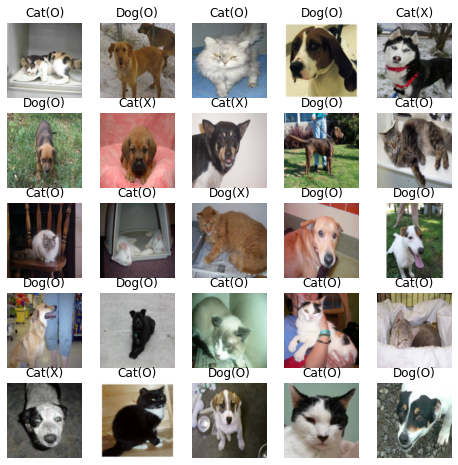

In [58]:
columns = 5
rows = 5
fig = plt.figure(figsize=(8,8))

model.eval()
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
for i in range(1, columns*rows+1):
    data_idx = np.random.randint(len(test_data))
    input_img = test_data[data_idx][0].unsqueeze(dim=0).to(device) 
    '''
    unsqueeze()를 통해 입력 이미지의 shape을 (1, 28, 28)에서 (1, 1, 28, 28)로 변환. 
    모델에 들어가는 입력 이미지의 shape은 (batch_size, channel, width, height) 되어야 함에 주의하세요!
    '''
    output = model(input_img)
    _, argmax = torch.max(output, 1)
    pred = argmax.item()
    label = test_data[data_idx][1]
    
    fig.add_subplot(rows, columns, i)
    pred_title = 'Cat' if pred == 0 else 'Dog'
    if pred == label:
        plt.title(pred_title + '(O)')
    else:
        plt.title(pred_title + '(X)')
    plot_img = test_data[data_idx][0]
    # 이미지를 normalization 이전 상태로 되돌리는 작업
    plot_img[0, :, :] = plot_img[0, :, :] * std[0] + mean[0]
    plot_img[1, :, :] = plot_img[1, :, :] * std[1] + mean[1]
    plot_img[2, :, :] = plot_img[2, :, :] * std[2] + mean[2]
    plot_img = transforms.functional.to_pil_image(plot_img)
    plt.imshow(plot_img)
    plt.axis('off')
plt.show()

## 11. Transfer Learning

실습을 끝내기전에, 우리는 **전이 학습(transfer learning)** 을 구현해 보고 성능을 확인해 볼 것입니다. 
전이학습이란 비슷한 목적으로 미리 학습된 모델의 파라미터로 나의 모델의 파라미터를 초기화한 후 학습을 이어서 진행하는 것을 말합니다. 그렇다면 이러한 전이학습은 어떤 장점이 있기에 사용하는 것일까요?

여러분이 현실에서 딥러닝을 활용할 때 흔히 마주칠 수 있는 현실적인 제약들이 있습니다. 데이터 부족, 컴퓨팅 리소스 부족, 시간의 부족이 대표적인 현실적인 제약들에 속합니다. 우리가 풀고자 하는 문제와 완전히 똑같지는 않지만 어느정도 연관성이 있는 문제를, 아주 많은 양의 데이터로, 미리 학습한 모델이 있다면 그 모델은 정말 아무것도 모르는 백지 상태의 모델보다 우리가 풀고 싶은 문제에 대해 훨씬 더 빨리 배우고 잘 배울 수 있습니다. 

구현은 전혀 어렵지 않습니다. 먼저 미리 학습된 모델을 불러와야 합니다. 
여기서 불러올 모델은 ResNet으로, 대규모 ImageNet 데이터로 이미지 분류를 학습한 모델입니다.

ResNet에 대해 잘 기억이 나지 않는다면 ['Lab-10-6'](https://www.youtube.com/watch?v=Qb_bYWcQXqY&list=PLQ28Nx3M4JrhkqBVIXg-i5_CVVoS1UzAv&index=25) 강의를 참고하시기 바랍니다.

다음 코드블록은 torchvision에 구현된 resnet50을 파라미터가 학습된 상태로 불러옵니다. 학습된 파라미터를 다운받기 위해 몇 분의 시간이 소요될 수 있습니다.

In [59]:
new_model = torchvision.models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

다만 우리가 앞서 직접 정의한 모델(SimpleCNN)에서는 입력 이미지의 크기를 120x120로 한 것에 반해, 방금 불러온 ResNet은 입력 이미지 크기를 최소한 224x224로 가정하고 학습된 모델입니다. 따라서 입력 데이터 크기만 수정하여 DataLoader를 다시 정의하도록 하겠습니다. 

In [60]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(224, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize([224, 224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

train_data = CatDogDataset(data_dir='./data/my_cat_dog', mode='train', transform=data_transforms['train'])
val_data = CatDogDataset(data_dir='./data/my_cat_dog', mode='val', transform=data_transforms['val'])
test_data = CatDogDataset(data_dir='./data/my_cat_dog', mode='test', transform=data_transforms['val'])

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=True)

우리가 불러온 ImageNet에 학습된 ResNet은 1000개의 class를 구분하는 네트워크입니다. 즉, 마지막 FC layer의 출력 뉴런 수가 1000개인 것입니다. 우리는 2개의 class를 구분하는 네트워크를 원하기 때문에, 마지막 FC layer만 출력을 2로 바꿔주고 이 부분에 대해서만 학습을 추가로 진행하면 됩니다.

상황에 따라서는 우리가 이번에 하는 것처럼 마지막 FC layer만 학습을 진행하는 것이 아니라 전체 네트워크에 대해서 학습을 이어서 진행하는 경우도 있습니다. 이를 파라미터 fine tuning(미세 조정)이라고 합니다. ImageNet에는 다양한 동물 class도 포함이 되어있습니다. 즉, 우리가 불러온 ResNet은 강아지와 고양이 같은 동물에 대한 특징을 이미 어느정도 잘 추출하는 네트워크인 것입니다. 따라서 fine tuning이 굳이 필요하지 않습니다. 게다가, 이번 실습과 같이 적은 양의 데이터를 통해 모델을 학습시키는 상황에서 fine tuning을 진행하는 것은 overfitting의 가능성이 커지는 것이기 때문에 오히려 성능을 낮추는 결과를 가져올 수 있습니다. 

이러한 내용을 아래 코드에 구현해두었습니다.
- [`nn.Module.parameters`](https://pytorch.org/docs/stable/nn.html?highlight=parameters#torch.nn.Module.parameters)를 통해 모델 파라미터에 대한 iterator를 가져올 수 있습니다. 먼저, 이 iterator를 통해 for문 을 돌며 모든 파라미터에 대해 [requires_grad](https://pytorch.org/docs/stable/autograd.html?highlight=requires_grad#torch.Tensor.requires_grad)를 False로 바꿔줍니다. 이렇게 하면 이 파라미터들에 대해서는 기울기가 계산되지 않기 때문에, 파라미터 업데이트가 되지 않습니다.
- 그 다음으로는 맨마지막 FC layer를 새로 정의해주는 것입니다. 그런데 문제는 마지막 FC layer에 어떻게 접근하느냐 입니다. 우리가 구현을 하지 않았기 때문에 마지막 layer의 입력 뉴런수가 어떻게 되는지도 모르는 상황입니다. 그러면 우리가 할 일은 구현된 코드를 보는 것입니다. torchvision에 우리가 불러온 ResNet이 구현되어 있습니다. [이곳](https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py#L146)에 가면 구현된 ResNet의 마지막 레이어의 변수명이 **self.fc**로 되어있음을 알 수 있습니다. 따라서 우리는 **모델.fc**와 같은 방식으로 이 layer에 접근할 수 있습니다. 이러한 방식으로 마지막 FC layer의 입력 뉴런수를 가져오고, 출력 뉴런 수는 우리의 문제에 맞게 2로 하여 마지막 layer를 수정할 수 있습니다. 

### <font color='red'>[TODO] 코드 구현</font>

다음을 읽고 코드를 완성해보세요.

1. 불러온 모델의 가장 마지막 FC layer의 이름은 'fc'임을 확인했습니다. 해당 레이어의 입력 뉴런 수를 `num_ftrs` 변수에 저장했습니다. 이제, 이 마지막 레이어에 새로운 FC layer를 정의하고, 그것의 입력 뉴런 수는 이전과 마찬가지로 `num_ftrs`로 하고 출력 뉴런 수는 우리가 분류하고자 하는 class의 총 개수로 해주세요,
2. 손실함수를 Cross Entropy Loss Function을 선언하고 이를 `criterion` 변수에 담습니다.
3. Adam 옵티마이저를 선언하고 이를 `optimizer` 변수에 담습니다. 인자로 넣어 주는 모델 파라미터는 새로 불러온 모델의 파라미터여야 함에 주의하세요. **<3. 하이퍼파라미터 세팅>** 에서 정의한 `learning_rate` 를 사용하세요.

**ResNet 의 최종 출력층을 바꾸고 손실함수 및 옵티마이저를 작성해보세요! "<font color='45A07A'>## 코드 시작 ##</font>"과 "<font color='45A07A'>## 코드 종료 ##</font>" 사이의 <font color='075D37'>None</font> 부분을 채우시면 됩니다.**

In [61]:
for param in new_model.parameters():
    param.requires_grad = False

num_ftrs = new_model.fc.in_features
## 코드 시작 ##
new_model.fc = nn.Linear(num_ftrs, 2, bias=True)    # 위의 설명 1. 을 참고하여 None을 채우세요.
criterion = nn.CrossEntropyLoss()       # 위의 설명 2. 를 참고하여 None을 채우세요.
new_model = new_model.to(device)
optimizer = torch.optim.Adam(new_model.parameters(), lr=learning_rate)       # 위의 설명 3. 을 참고하여 None을 채우세요.
## 코드 종료 ##
val_every = 1
saved_dir = './saved/ResNet50'

아래의 코드를 실행해 코드를 성공적으로 완성했는지 확인해보세요. 

별다른 문제가 없다면 이어서 진행하면 됩니다.

In [62]:
checker.final_fc_check(new_model)

마지막 FC layer 잘 수정하셨습니다! 이어서 진행하셔도 좋습니다.


불러온 모델에 대해 학습을 진행합니다. 이 과정도 100분 내외의 시간이 소요됩니다. 마찬가지로 적당히 학습이 진행되는 것만 보고 중단후 다음 단계로 넘어가셔도 됩니다.

In [63]:
train(num_epochs, new_model, train_loader, criterion, optimizer, saved_dir, val_every, device)

Start training..
Epoch [1/10], Step [3/20], Loss: 0.5991, Accuracy: 77.00%
Epoch [1/10], Step [6/20], Loss: 0.5900, Accuracy: 80.00%
Epoch [1/10], Step [9/20], Loss: 0.5579, Accuracy: 84.00%
Epoch [1/10], Step [12/20], Loss: 0.5751, Accuracy: 72.00%
Epoch [1/10], Step [15/20], Loss: 0.5326, Accuracy: 83.00%
Epoch [1/10], Step [18/20], Loss: 0.5034, Accuracy: 87.00%
Start validation #1
Validation #1  Accuracy: 92.00%  Average Loss: 0.4701
Best performance at epoch: 1
Save model in ./saved/ResNet50
Epoch [2/10], Step [3/20], Loss: 0.4786, Accuracy: 91.00%
Epoch [2/10], Step [6/20], Loss: 0.4457, Accuracy: 93.00%
Epoch [2/10], Step [9/20], Loss: 0.4309, Accuracy: 89.00%
Epoch [2/10], Step [12/20], Loss: 0.3738, Accuracy: 97.00%
Epoch [2/10], Step [15/20], Loss: 0.4105, Accuracy: 94.00%
Epoch [2/10], Step [18/20], Loss: 0.3654, Accuracy: 98.00%
Start validation #2
Validation #2  Accuracy: 95.10%  Average Loss: 0.3610
Best performance at epoch: 2
Save model in ./saved/ResNet50
Epoch [3/10],

전이 학습을 마친 후, 훈련 단계에서 최고 성능을 보인 파라미터를 불러오고, 그 성능을 확인합니다. 마찬가지로 위에서 학습을 끝까지 진행하지 않았다면 아래 주석부분을 해제하시기 바랍니다.

### <font color='red'>[TODO] 코드 구현</font>

다음을 읽고 코드를 완성해보세요. 

1. `model_path`의 경로에 있는 모델 파일을 로드하여, 이를 `check_point` 변수에 저장합니다. 또한, 미리저장된 모델이 GPU로 학습했는데 CPU 로 불러올 경우, 파이토치에서 모델을 불러오는 함수에 `map_location` 인자에 `device` 정보를 전달해야 적용됩니다. (즉, 함수에 `map_location=device` 가 되어야 합니다.) `device` 변수는 **<1. Package load>** 에서 이미 선언했습니다.
2. `check_point` 딕셔너리에 접근하여 모델의 파라미터를 `state_dict` 변수에 저장합니다. 접근을 위한 딕셔너리의 키값은 'net' 입니다.
3. `state_dict`의 파라미터들을 ResNet 모델(`new_model`)에 로드합니다.

In [64]:
model_path = './saved/ResNet50/best_model.pt'
# model_path = './saved/pretrained/ResNet50/best_model.pt' # 모델 학습을 끝까지 진행하지 않은 경우에 사용

## 코드 시작 ##
checkpoint = torch.load(model_path,map_location=device)    # 위의 설명 1. 을 참고하여 None을 채우세요.
state_dict = checkpoint['net']    # 위의 설명 2. 를 참고하여 None을 채우세요.
model.load_state_dict(state_dict)                 # 위의 설명 3. 을 참고하여 None을 채우세요.
## 코드 종료 ##

RuntimeError: ignored

테스트를 수행합니다. 정확도가 97% 내외가 나온다면 성공적으로 진행된 것입니다. 겨우 마지막 FC layer만 학습시켰음에도 불구하고 우리의 SimpleCNN보다 성능이 훨씬 좋은 것을 볼 수 있습니다.

In [ ]:
test(new_model, test_loader, device)

학습된 모델의 예측 결과를 시각화하면 다음과 같습니다. 

In [ ]:
columns = 5
rows = 5
fig = plt.figure(figsize=(8,8))

model.eval()
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
for i in range(1, columns*rows+1):
    data_idx = np.random.randint(len(test_data))
    input_img = test_data[data_idx][0].unsqueeze(dim=0).to(device) 
    '''
    unsqueeze()를 통해 입력 이미지의 shape을 (1, 28, 28)에서 (1, 1, 28, 28)로 변환. 
    모델에 들어가는 입력 이미지의 shape은 (batch_size, channel, width, height) 되어야 함에 주의하세요!
    '''
    output = new_model(input_img)
    _, argmax = torch.max(output, 1)
    pred = argmax.item()
    label = test_data[data_idx][1]
    
    fig.add_subplot(rows, columns, i)
    pred_title = 'Cat' if pred == 0 else 'Dog'
    if pred == label:
        plt.title(pred_title + '(O)')
    else:
        plt.title(pred_title + '(X)')
    plot_img = test_data[data_idx][0]
    # 이미지를 normalization 이전 상태로 되돌리는 작업
    plot_img[0, :, :] = plot_img[0, :, :] * std[0] + mean[0]
    plot_img[1, :, :] = plot_img[1, :, :] * std[1] + mean[1]
    plot_img[2, :, :] = plot_img[2, :, :] * std[2] + mean[2]
    plot_img = transforms.functional.to_pil_image(plot_img)
    plt.imshow(plot_img)
    plt.axis('off')
model.train()
plt.show()

## 12. Summary

여기까지 오신 여러분 잘하셨습니다! 

우리는 이번 실습을 통해 다음과 같은 내용을 학습했습니다.

- Dataset class를 우리가 가진 데이터셋에 맞게 customize 하여 정의할 수 있다.
- CNN을 설계하고 이미지 분류기를 학습시킬 수 있다.
- 학습된 모델을 저장하고 불러올 수 있다.
- 데이터, 리소스, 시간이 부족한 상황에서 전이학습을 사용하여 이를 극복할 수 있다.

---

# Self-Review

학습 환경에 맞춰 알맞는 제출방법을 실행하세요!

### 로컬 환경 실행자

1. 모든 실습 완료 후, Jupyter Notebook 을 `Ctrl+S` 혹은 `File > Save and checkpoint`로 저장합니다.
2. 제일 하단의 코드를 실행합니다. 주의할 점은 Jupyter Notebook 의 파일이름을 수정하시면 안됩니다! 만약에 노트북 이름을 수정했다면 "pytorch-cnn-project" 로 바꿔주시길 바랍니다. 모든 평가 기준을 통과하면, 함수 실행 후 프로젝트 "submit" 디렉토리와 압축된 "submit.zip"이 생깁니다. "cnn_submission.tsv" 파일을 열고 모두 Pass 했는지 확인해보세요!
    * "cnn_submission.tsv" : 평가 기준표에 근거해 각 세부항목의 통과여부(Pass/Fail) 파일
    * "cnn_submission.html" : 여러분이 작성한 Jupyter Notebook 을 html 형식으로 전환한 파일
3. 코드 실행결과 안내에 따라서 `submit.zip` 파일을 확인하시고 제출해주시길 바랍니다.

### Colab 환경 실행자

1. 모든 실습 완료 후, Jupyter Notebook 을 `Ctrl+S` 로 저장합니다.
2. 제일 하단의 코드를 실행합니다. 코드 실행결과 안내에 따라서 재작성하거나 다음스텝으로 넘어갑니다. 모든 평가 기준을 통과하면, 함수 실행 후 프로젝트 "submit" 디렉토리와 압축된 "cnn_submission.tsv"만 생깁니다. "cnn_submission.tsv" 파일을 열고 모두 Pass 했는지 확인해보세요!
    * "cnn_submission.tsv" : 평가 기준표에 근거해 각 세부항목의 통과여부(Pass/Fail) 파일
3. 프로젝트를 저장한 드라이브의 `submit` 폴더에서 `cnn_submission.tsv` 파일을 다운 받습니다.
4. Colab Notebook 에서 `파일 > .ipynb 다운로드`를 통해서 노트북을 다운로드 받습니다.
5. 로컬에서 Jupyter Notebook 프로그램을 실행시킵니다. 
6. 4번 스텝에서 다운받은 노트북을 열고 `File > Download as > HTML(.html)` 로 재 다운로드 합니다.
7. 3번 스텝에서 받은 파일과 6번 스텝에서 받은 파일을 하나의 폴더에 넣고, `submit.zip` 이라는 이름으로 압축하고 제출해주시길 바랍니다.

In [ ]:
import check_util.submit as submit
submit.process_submit()